In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

EEG_PROJECT_PATH = "."
CHECKPOINT_PATH = os.path.join(EEG_PROJECT_PATH, "checkpoints")
CONFIG_DIR = os.path.join(EEG_PROJECT_PATH, "configs")
DEFAULT_CONFIG = "tta_energy.yaml"

In [3]:
import yaml
 
with open(os.path.join(CONFIG_DIR, DEFAULT_CONFIG)) as f:
    config = yaml.safe_load(f)

In [4]:
config

{'source_run': 'src-bcic2a_loso_2023-12-04_14-41-13',
 'tta_method': 'energy_adaptation',
 'continual': False,
 'tta_config': {'alignment': False,
  'averaging_method': 'ema',
  'align_alpha': 0.1,
  'buffer_length': 32,
  'langevin_init': {'series_length': 1000},
  'optimizer': 'Adam',
  'optimizer_kwargs': {'lr': 0.005, 'beta': 0.9, 'weight_decay': 0.0}}}

In [5]:
import torch 
from eeg_otta.models import BaseNet
from eeg_otta.utils.get_datamodule_cls import get_datamodule_cls
from eeg_otta.utils.seed import seed_everything


with open(os.path.join(CHECKPOINT_PATH, config["source_run"], "config.yaml")) as f:
    source_config = yaml.safe_load(f)
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

seed_everything(source_config["seed"])

datamodule_cls = get_datamodule_cls(source_config["dataset_name"])
model_cls = BaseNet

Tensorflow not install, you could not use those pipelines
Setting all random seeds to 0, cuda_available=False


In [6]:
SUBJECT_ID = 1
ckpt_path = os.path.join(CHECKPOINT_PATH, config["source_run"], str(SUBJECT_ID), "model-v1.ckpt")

model = model_cls.load_from_checkpoint(ckpt_path, map_location=device)

datamodule = datamodule_cls(source_config["preprocessing"], subject_ids=[SUBJECT_ID])
datamodule.subject_id = SUBJECT_ID
datamodule.prepare_data()
datamodule.setup()

48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events foun

/home/lhorns/miniconda3/envs/eeg/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scale is deprecated; will be removed in 0.8.0. Use numpy.multiply inside a lambda function instead.
  warnings.warn(msg, category=FutureWarning)


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [15]:
from eeg_otta.tta.energy_adaptation import EnergyAdaptation

energy_model = EnergyAdaptation(model, config["tta_config"], datamodule.info)

#Trainable/total parameters: 224/3692


In [16]:
datamodule.train_dataset[0]

(tensor([[ 0.0496,  0.0384,  0.0172,  ..., -0.0210, -0.0364, -0.0478],
         [ 0.0239,  0.0219,  0.0104,  ..., -0.0333, -0.0396, -0.0400],
         [ 0.0088,  0.0242,  0.0444,  ...,  0.0281,  0.0217,  0.0230],
         ...,
         [ 0.0039, -0.0058, -0.0079,  ...,  0.0016,  0.0040,  0.0085],
         [-0.0129, -0.0162, -0.0220,  ..., -0.0084, -0.0088, -0.0057],
         [ 0.0933,  0.0723,  0.0436,  ...,  0.0047, -0.0017, -0.0115]]),
 tensor(1))

In [17]:
def plot_sample(eeg, label=None):
    plt.figure(figsize=(12, 6))
    for i in range(eeg.shape[0]):
        plt.plot(eeg[i] + i * 0.25, label=f"Channel {i+1}")  # offset each channel for clarity
    
    plt.title(f"EEG Window 0 - Label: {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (uV, offset for visibility)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
    plt.tight_layout()
    plt.show()

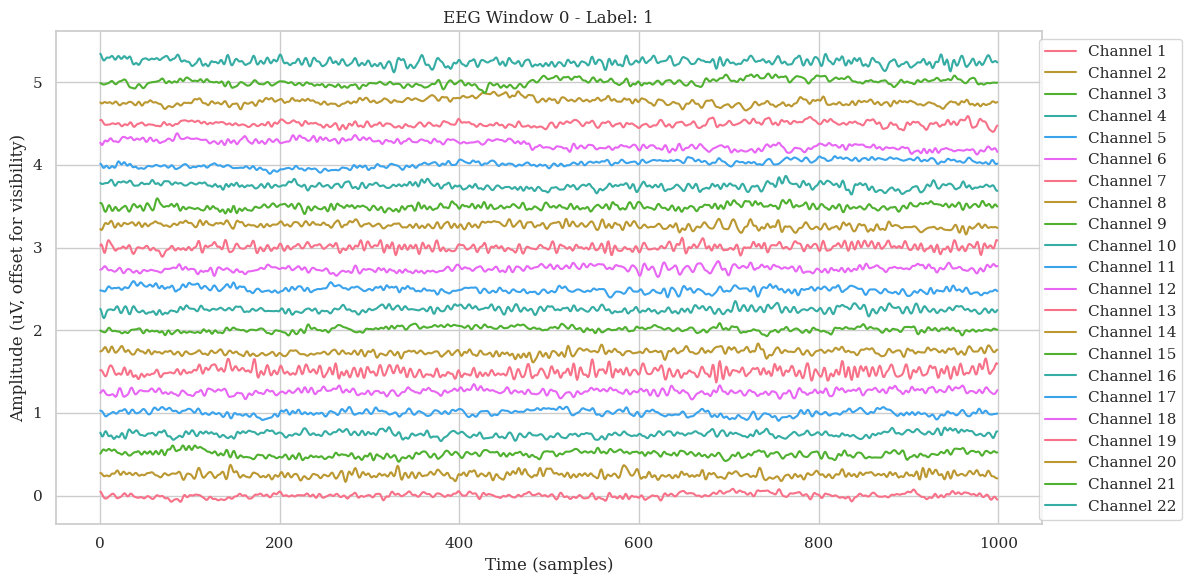

In [18]:
from matplotlib import pyplot as plt

real_sample = datamodule.train_dataset[0]
eeg = real_sample[0]
label = real_sample[1]

plot_sample(eeg, label)

In [19]:
def plot_first_k_mean(l=0, k=3):
    plt.figure(figsize=(12, 6))
    
    ct = 0
    idx = 0
    while ct < k:
        real_sample = datamodule.train_dataset[idx]
        idx += 1
        eeg = real_sample[0]  # shape: (n_channels, n_times)
        label = real_sample[1]
        
        if label == l: 
            ct += 1
            mean_signal = eeg.mean(axis=0)
        
            plt.plot(mean_signal, label=f"Sample {idx} - Label {label}")
    
    plt.title(f"Mean EEG signal across channels, class {l}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Mean Amplitude (uV)")
    #plt.legend()
    plt.tight_layout()
    plt.show()

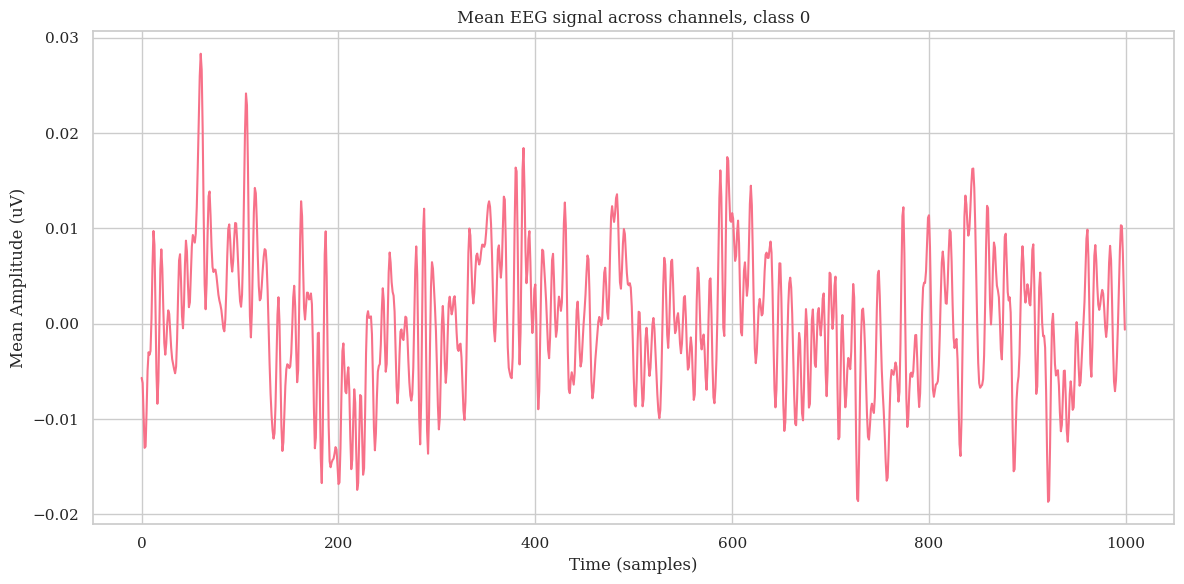

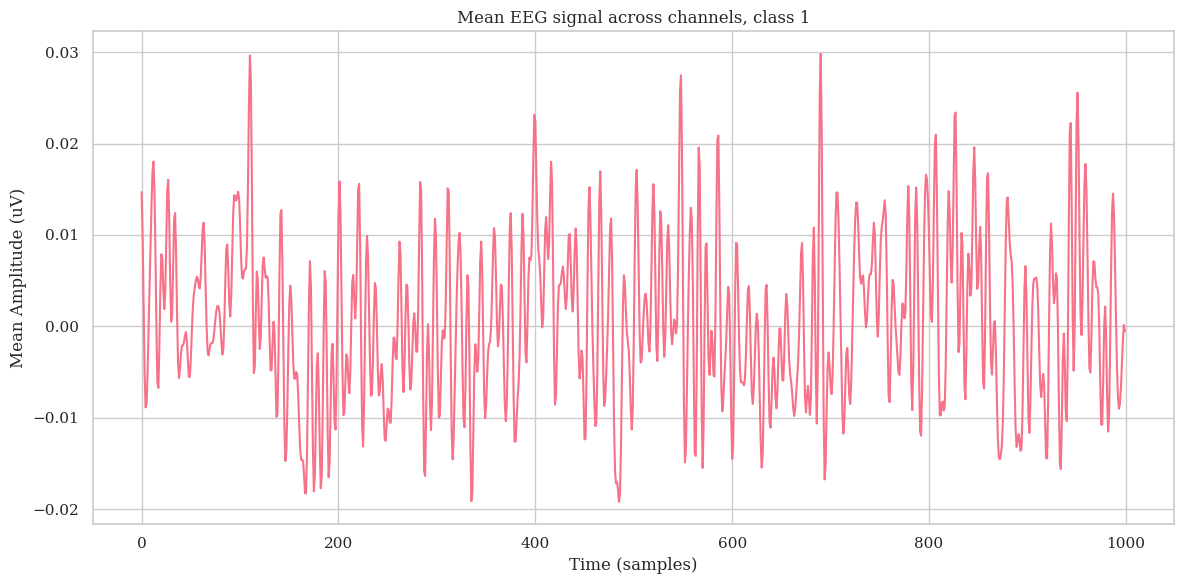

In [20]:
plot_first_k_mean(0, 1)
plot_first_k_mean(1, 1)

In [21]:
real_sample = datamodule.dataset[0]
eeg = real_sample[0]
eeg.shape

(22, 1000)

In [46]:
energy_model._init_langevin_initial_dist(
    series_length=1000,
    kernel="rbf",
    length=5,
    scale=0.03,
)

x_fake, x_init = energy_model.sample_q(
    n_steps=1000,
    sgld_lr=0.1, 
    sgld_std=0.000, 
    reinit_freq=0.05,
    batch_size=1, 
    series_length=1000, 
    n_channels=22, 
    device=device, 
    y=None)

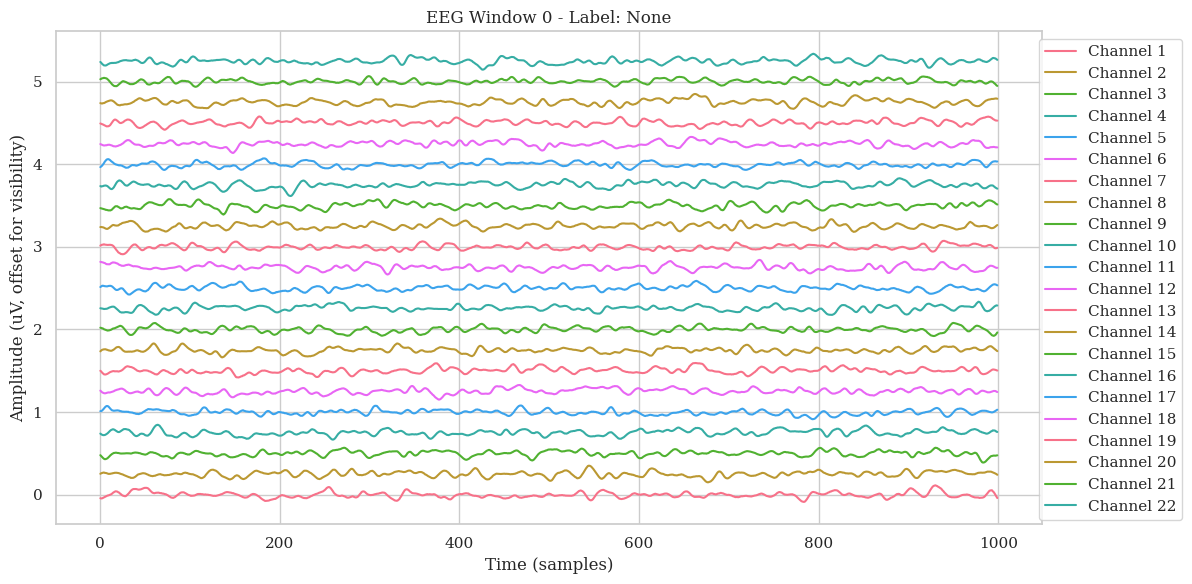

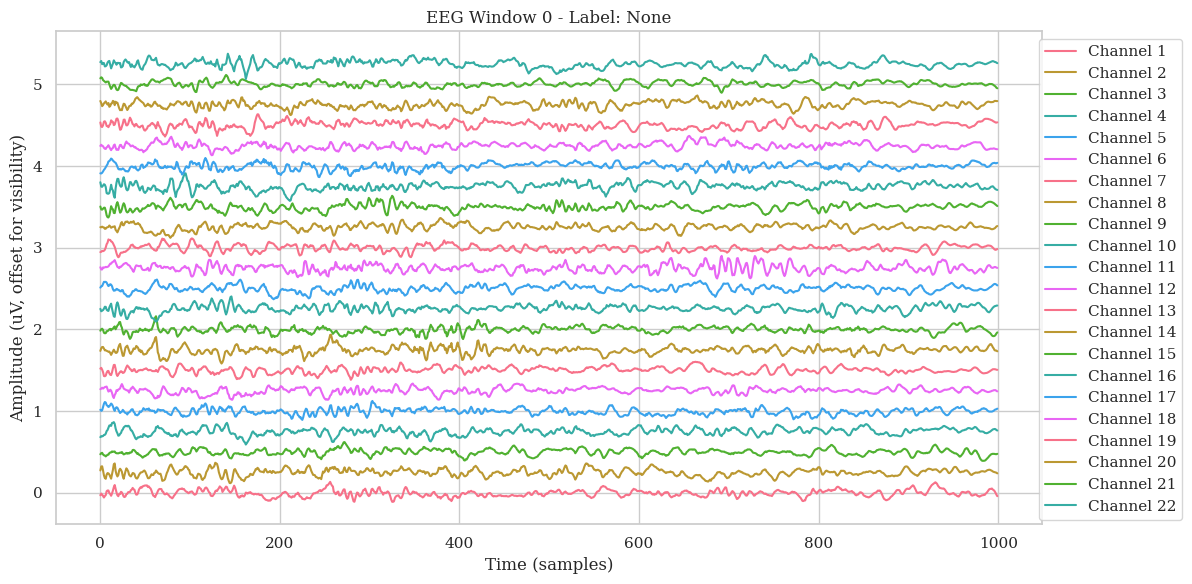

In [47]:
plot_sample(x_init[0])
plot_sample(x_fake[0])

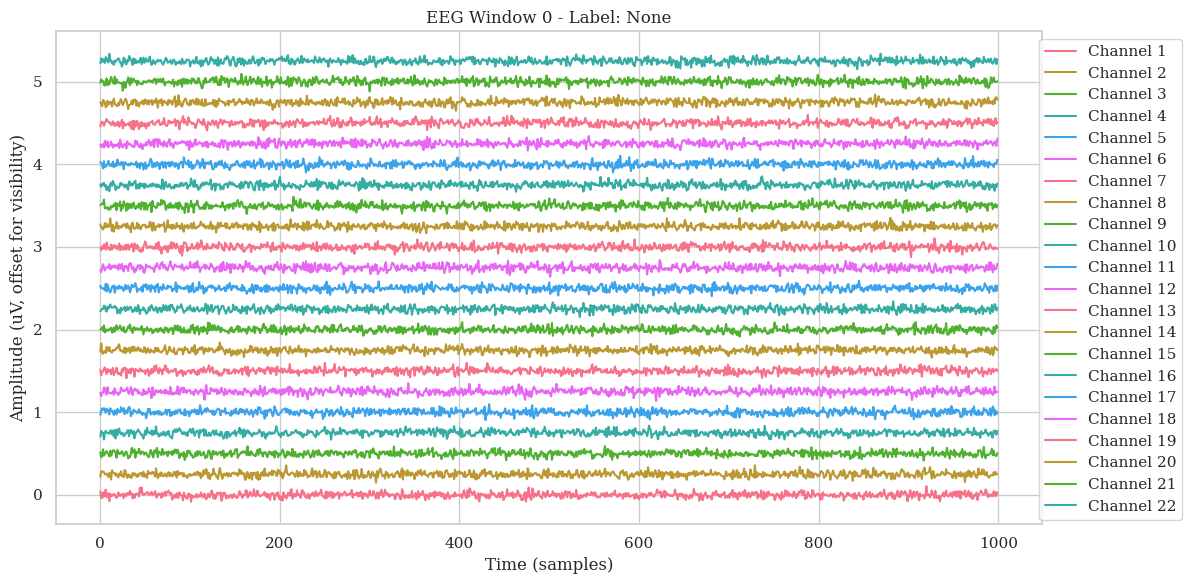

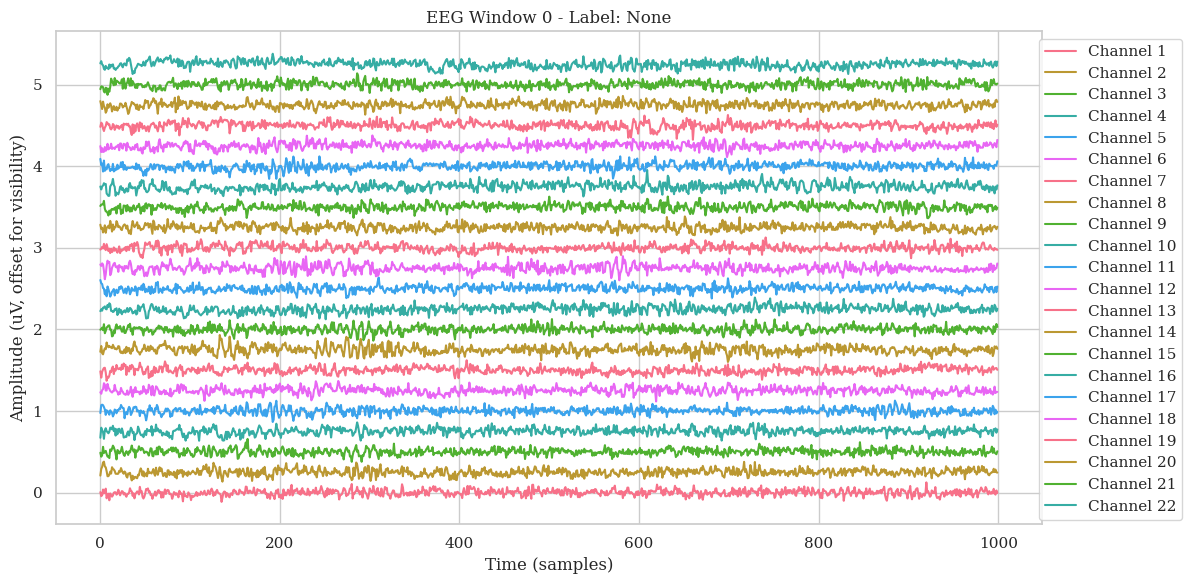

In [45]:
plot_sample(x_init[0])
plot_sample(x_fake[0])

In [29]:
def plot_all_k_mean(samples, k=3):
    plt.figure(figsize=(12, 6))
    
    for i in range(k):
        eeg = samples[i]  # shape: (n_channels, n_times)
        mean_signal = eeg.mean(axis=0) 
        plt.plot(mean_signal, label=f"Sample {i}")
    
    plt.title(f"Mean EEG fake signal across channels")
    plt.xlabel("Time (samples)")
    plt.ylabel("Mean Amplitude (uV)")
    #plt.legend()
    plt.tight_layout()
    plt.show()

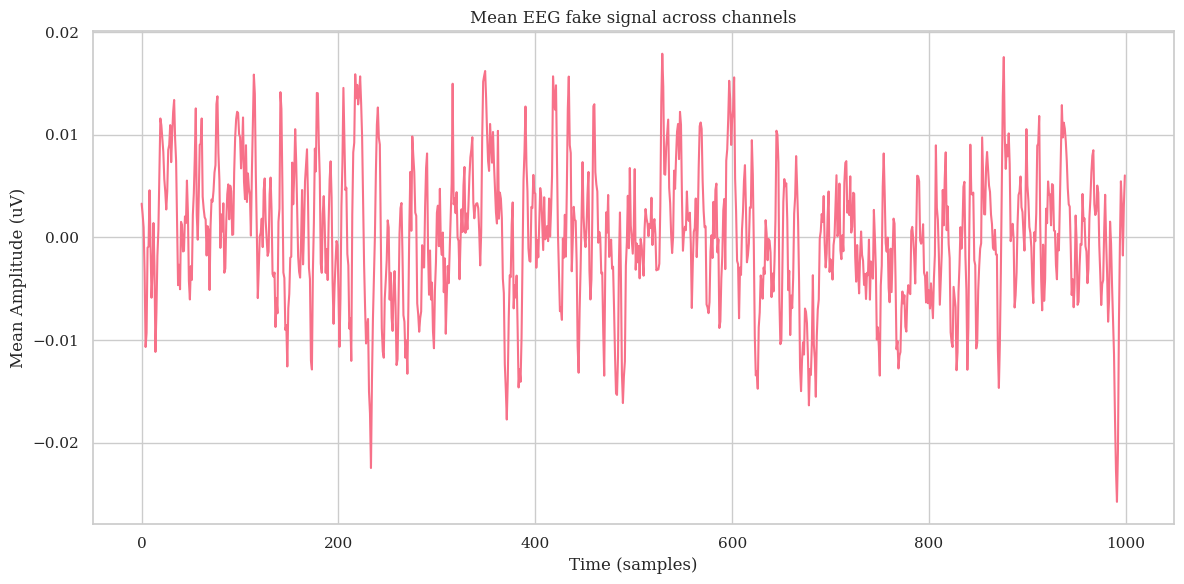

In [30]:
plot_all_k_mean(x_fake, 1)